# Определение перспективного тарифа для телеком-компании 

## Описание проета

Клиентам предлагается два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

## Описание тарифов

### Тариф "Смарт"
1. Ежемесячная плата: 550 рублей;
2. Включено:
    . 500 минут разговора;
    . 50 сообщений;
    . 15 Гб интернет-трафика.
3. Стоимость сверх-тарифного пакета:
    . 1 минута разговора - 3 рубля;
    . 1 сообщение - 3 рубля;
    . 1 Гб интернет-трафика: 200 рублей.
    
### Тариф "Ультра"
1. Ежемесячная плата: 1950 рублей;
2. Включено:
    . 3000 минут разговора;
    . 1000 сообщений;
    . 30 Гб интернет-трафика.
3. Стоимость сверх-тарифного пакета:
    . 1 минута разговора - 1 рубль ;
    . 1 сообщение - 1 рубль;
    . 1 Гб интернет-трафика: 150 рублей.
    
**Примечание:**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Содержание
1. [Изучение общей информации о данных](#1)
2. [Предобработка данных](#2)
    - [Обработка пропусков](#2_1)
    - [Приведение данных к соответствующему типу](#2_2)
    - [Поиск дубликатов](#2_3)
    - [Количество сделанных звонков и израсходованных минут разговора по месяцам](#2_4)
    - [Количество отправленных сообщений по месяцам](#2_5)
    - [Объем израсходованного интернет-трафика по месяцам](#2_6)
    - [Расчет помесячной выручки с каждого пользователя](#2_7)
3. [Исследовательская часть](#3)
    - [Сколько минут разговора](#3_1)
    - [Сколько сообщений](#3_2)
    - [Какой объем интернет-трафика](#3_3)
    - [Проверка гипотез](#3_4)
4. [Общий вывод](#4)

## Изучение общей информации о данных <a id="1"></a>

Для начала работы, загрузим всю необходимую информацию и ознакомимся с данными. Для этого подключим все необходимые пакеты и модули.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
try:
    calls = pd.read_csv('datasets/calls.csv')
    internet = pd.read_csv('datasets/internet.csv')
    messages = pd.read_csv('datasets/messages.csv')
    tariffs = pd.read_csv('datasets/tariffs.csv')
    users = pd.read_csv('datasets/users.csv')
except:
    calls = pd.read_csv('/datasets/calls.csv')
    internet = pd.read_csv('/datasets/internet.csv')
    messages = pd.read_csv('/datasets/messages.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')
    users = pd.read_csv('/datasets/users.csv') 

Теперь ознакомимся с информацией о клиентах подробнее.

**`Calls` (информация о звонках)**

In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Информация о таблице:
- `id` - уникальный номер звонка;
- `call_date` - дата звонка;
- `duration` - длительность звонка в минутах;
- `user_id` - идентификатор пользователя, сделавшего звонок

Предварительно можно сказать следующее:
- информации по признакам в таблице достаточно, чтобы понять, какие данные находятся в информации о звонках;
- явных пропусков нет.
- имеется некорректный тип данных (`duration` - `float`, `call_date` - `object`)

**`Internet` (информация об интернет-сессиях)**

In [5]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [6]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Информация о таблице:
- `id` - уникальный номер сессии;
- `mb_used` - объём потраченного за сессию интернет-трафика (в мегабайтах);
- `session_date` - дата_интернет-сессии;
- `user_id` - идентификатор пользователя.

Предварительно можно сказать следующее:
- информации по признакам в таблице достаточно, чтобы понять, какие данные находятся в информации о звонках;
- явных пропусков нет.
- имеется некорректный тип данных (`mb_used` - `float`, `session_date` - `object`)
- нет информации о том, что за столбец **Unnamed**, который, предположительно, дублирует индексы таблицы. Для нас он не нужен. Удалим его.

In [7]:
internet = internet.drop(columns = 'Unnamed: 0')

Проверим, что столбец удалился

In [8]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


**`messages` (информация о сообщениях)**

In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [10]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Информация о таблице:
- `id` - уникальный номер сессии;
- `message_date` - дата сообщения;
- `user_id` - идентификатор пользователя.

Предварительно можно сказать следующее:
- информации по признакам в таблице достаточно, чтобы понять, какие данные находятся в информации о звонках;
- явных пропусков нет.
- имеется некорректный тип данных (`message_date` - `object`)

**`users` (информация о пользователях)**

In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [12]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Информация о таблице:
- `user_id ` - уникальный номер сессии;
- `first_name` - имя пользователя;
- `last_name` - фамилия  пользователя;
- `age` - возраст пользователя (годы);
- `reg_date` - дата подключения тарифа (день, месяц, год);
- `churn_date` - дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных);
- `city` - город проживания пользователя;
- `tarif` - название тарифного плана.

Предварительно можно сказать следующее:
- информации по признакам в таблице достаточно, чтобы понять, какие данные находятся в информации о звонках;
- Имеются явные пропуски в столбце `churn_date`, однако из дополнительной информации известно, что пропуск в этом столбце: тариф еще действовал на момент загрузки данных:
> если значение пропущено, то тариф ещё действовал на момент выгрузки данных
- имеется некорректный тип данных (`reg_date` - `object`, `churn_date` - `object`)

**`tariffs` (информация о тарифах)**

In [13]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [14]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Информация о таблице:
- `tariff_name` - название тарифа;
- `rub_monthly_fee` - ежемесячная абонентская плата в рублях;
- `minutes_included` - количество минут разговора в месяц, включённых в абонентскую плату;
- `messages_included` - количество сообщений в месяц, включённых в абонентскую плату;
- `mb_per_month_included` - объём интернет-трафика, включённого в абонентскую плату (в мегабайтах);
- `rub_per_minute` - стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата);
- `rub_per_message` - стоимость отправки сообщения сверх тарифного пакета;
- `rub_per_gb` -  стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта).

Предварительно можно сказать следующее:
- информации по признакам в таблице достаточно, чтобы понять, какие данные находятся в информации о звонках;

### Вывод 

На основе полученной информации можно сказать следующее:

| Таблица | Выводы |
| :-----: |:-----:|
| **`Calls` (информация о звонках)** |информации по признакам в таблице достаточно, чтобы понять, какие данные находятся в информации о звонках; явных пропусков нет; имеется некорректный тип данных (`duration` - `float`, `call_date` - `object`)|
|**`Internet` (информация об интернет-сессиях)**|информации по признакам в таблице достаточно, чтобы понять, какие данные находятся в информации о звонках; явных пропусков нет; имеется некорректный тип данных (`mb_used` - `float`, `session_date` - `object`)|
|**`messages` (информация о сообщениях)**|информации по признакам в таблице достаточно, чтобы понять, какие данные находятся в информации о звонках; явных пропусков нет; имеется некорректный тип данных (`message_date` - `object`)|
|**`users` (информация о пользователях)**|информации по признакам в таблице достаточно, чтобы понять, какие данные находятся в информации о звонках; имеются явные пропуски; имеется некорректный тип данных (`reg_date` - `object`, `churn_date` - `object`)|
|**`tariffs` (информация о тарифах)**|информации по признакам в таблице достаточно, чтобы понять, какие данные находятся в информации о звонках;|

На основе этой таблицы можно сказать, что у нас есть явные пропуски и тип данных во всех таблицах в параметре, связанным со временем приведен некорректно. 

Необходимо дополнительно прелобработать данные и првести их в порядок, прежде чем начать исследование данных.

## Предобработка данных <a id="2"></a>

Для начала вспомним, что у нас есть явные проблемы в таблицах:
- у нас есть пропуск в столбце `churn_date` таблицы **users**;
- неверный формат даты во всех столбцах (представлен типом `object`, который необходимо привести к типу `date_time`).

### Обработка пропусков<a id="2_1"></a>

Сперва посмотрим на таблицу **users**, чтобы понять, сколько у нас таких пропусков.

In [15]:
users.isna().mean()

user_id       0.000
age           0.000
churn_date    0.924
city          0.000
first_name    0.000
last_name     0.000
reg_date      0.000
tariff        0.000
dtype: float64

In [16]:
users.notna().sum()

user_id       500
age           500
churn_date     38
city          500
first_name    500
last_name     500
reg_date      500
tariff        500
dtype: int64

Практичеки 93% информации по этому признаку пропущено у пользователей. Однако вспомним, что:
>  если значение пропущено, то тариф ещё действовал на момент выгрузки данных

Это говорит нам о том, что 38 клиентов в процессе сбора информации отказались от своих тарифов.

Посмотрим, сколько клиентов и каким тарифами они пользовались, прежде чем отказаться от его использования. На основе этой информации можно предположить, какой тариф оказался более невыгодным для клиентов мобильного оператора.

In [17]:
user_drop_tarif = users[users.churn_date.isna() == False]
user_drop_tarif.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
19,1019,63,2018-10-05,Томск,Игнатий,Круглов,2018-05-16,ultra
20,1020,59,2018-12-18,Чита,Тала,Костина,2018-10-22,smart
34,1034,66,2018-11-21,Вологда,Святослав,Бондарев,2018-08-26,smart
50,1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra
51,1051,37,2018-10-14,Москва,Кристина,Сомова,2018-05-28,smart


In [18]:
user_pivot = user_drop_tarif.pivot_table(index = 'tariff', 
                                              values = 'user_id',
                                             aggfunc = 'count').reset_index()
user_pivot['propotion'] = (user_pivot.user_id/user_pivot.user_id.sum())*100
user_pivot['propotion'] = user_pivot['propotion'].map('{:.2f}'.format)
user_pivot.columns = ['Название тарифа',
                      'Количесвто пользователей, которые отказались от тарифа', 
                      'Доля пользователей, %']
user_pivot

,Название тарифа,"Количесвто пользователей, которые отказались от тарифа","Доля пользователей, %"
0,smart,23,60.53
1,ultra,15,39.47


Видим, что доля пользователей, которые отказались от тарифа "Смарт" больше тех, кто отказался от тарифа "Ультра". Предположений может быть несколько:
- Тариф не выгоден по услугам сверх тарифного плана. Стоимость за превышение трафика высока: звонки и смс - 3 рубля за каждое превышение тарифа, интернет - 200 рублей за 1 гигабайт дополнительного трафика. Стоимость интернета высокая и возможно пользователям не хвататет пакета гигагбайтов в тарифе. Поэтому и прекращают пользоваться этим тарифом.
- Тариф просто не нужен из-за ненужных позиций и наличия более-выгодных предложений у конкурентов.

По тарифу "Ультра" можно сказать следующее:
- Пользователи могли отказать от него, потому что тариф слишком дорогой, не каждый пользователь может себе позволить платить 1950 рублей в месяц на постоянно основе;
- Ознакомившись с тарифным планом, можно предположить, что некоторым пользователям пакета будет слишком много в месяц, поэтому люди и отказывались от него
Однако данных у нас на данный момент недостаточно для формулирования окончательного вывода, Поэтому необходимо проводить дополнительный анализ пользователей: как часто пользуются услугами тарифа? Какими именно услугами пользуются? Это будет рассматриваться в дальнейшем.

Вернемся к пропускам в этом столбце. Так как известно, что
> если значение пропущено, то тариф ещё действовал на момент выгрузки данных

то можно предожить следующие варианты заполнения пропуска:
- заполнить нестандартным значением, так мы ясно для себя дадим понять, что у нас есть пользователи, которые им пользуются, а есть те, которые уже отказались
- оставить как есть, так как в дополнительной информации была указана причина пропуска в этом столбце.

Выберем последний вариант: **оставим как есть**.

Теперь посмотрим на уникальные позиции каждого столбца в этой таблице. Вдруг у нас имеются неявные пропуски, о которых мы не знаем.

In [19]:
# функция получения уникальных значений столбцов и количество их упоминаний
# df- таблица, в которой ищем неявные пропуски и аномалии
def take_unique_values(df):
    for column in df.columns:
        print(f'Уникальные значения в {column}', 
              df[column].value_counts().head(), 
              sep = '\n')
        print()

In [20]:
take_unique_values(users)

Уникальные значения в user_id
1023    1
1194    1
1181    1
1182    1
1183    1
Name: user_id, dtype: int64

Уникальные значения в age
53    14
42    14
63    13
71    13
64    13
Name: age, dtype: int64

Уникальные значения в churn_date
2018-12-03    2
2018-12-21    2
2018-10-14    2
2018-12-09    2
2018-10-03    2
Name: churn_date, dtype: int64

Уникальные значения в city
Москва             99
Санкт-Петербург    39
Новосибирск        16
Омск               14
Казань             14
Name: city, dtype: int64

Уникальные значения в first_name
Радим     6
Леонид    5
Пётр      5
Андрей    4
Тамара    4
Name: first_name, dtype: int64

Уникальные значения в last_name
Андреенко    5
Озерова      3
Аркадьев     3
Абашкина     3
Березина     3
Name: last_name, dtype: int64

Уникальные значения в reg_date
2018-05-28    8
2018-04-03    5
2018-10-05    5
2018-07-16    5
2018-11-16    5
Name: reg_date, dtype: int64

Уникальные значения в tariff
smart    351
ultra    149
Name: tariff, dtype: int64



Видим, что у нас неявных пропусков нет, поэтому остается изменить тип данных в некоторых столбцах. Рассмотрим этот момент в следующем разделе.

Теперь рассмотрим оставшиеся таблицы, чтобы понять, есть ли у нас неявные пропуски в данных

**`tariffs` (информация о тарифах)**

In [21]:
take_unique_values(tariffs)

Уникальные значения в messages_included
50      1
1000    1
Name: messages_included, dtype: int64

Уникальные значения в mb_per_month_included
30720    1
15360    1
Name: mb_per_month_included, dtype: int64

Уникальные значения в minutes_included
3000    1
500     1
Name: minutes_included, dtype: int64

Уникальные значения в rub_monthly_fee
550     1
1950    1
Name: rub_monthly_fee, dtype: int64

Уникальные значения в rub_per_gb
150    1
200    1
Name: rub_per_gb, dtype: int64

Уникальные значения в rub_per_message
3    1
1    1
Name: rub_per_message, dtype: int64

Уникальные значения в rub_per_minute
3    1
1    1
Name: rub_per_minute, dtype: int64

Уникальные значения в tariff_name
ultra    1
smart    1
Name: tariff_name, dtype: int64



Видим, что у нас все хорошо в с информацией о тарифах - нет неявных пропусков или аномалий.

**`messages` (информация о сообщениях)**

In [22]:
take_unique_values(messages)

Уникальные значения в id
1203_164    1
1332_101    1
1276_39     1
1216_72     1
1385_49     1
Name: id, dtype: int64

Уникальные значения в message_date
2018-12-31    859
2018-12-30    765
2018-12-21    712
2018-12-29    702
2018-12-28    699
Name: message_date, dtype: int64

Уникальные значения в user_id
1277    1463
1089    1408
1231    1384
1385    1380
1356    1224
Name: user_id, dtype: int64



Предновогодняя суета, не иначе)

Видно, что у нас все хорошо с информацией о сообщениях - нет неявных пропусков. Однако видно, что есть пользователи, которые очень часто пользуются отправкой сообщений. И видно, что в канун Нового года количество сообщений высок.

**`Internet` (информация об интернет-сессиях)**

In [23]:
take_unique_values(internet)

Уникальные значения в id
1196_216    1
1211_50     1
1185_180    1
1414_419    1
1373_188    1
Name: id, dtype: int64

Уникальные значения в mb_used
0.00      19598
197.56        9
447.30        9
335.91        9
108.95        8
Name: mb_used, dtype: int64

Уникальные значения в session_date
2018-12-31    1057
2018-12-30     903
2018-12-25     859
2018-12-26     844
2018-12-22     834
Name: session_date, dtype: int64

Уникальные значения в user_id
1496    834
1227    812
1204    789
1240    764
1251    759
Name: user_id, dtype: int64



А вот тут мы видим, что у нас есть объем потраченного за сессию интернет-трафика в мегабайтах, которого большего всего равен нулю. 
Можно предположить следующие причины:
- люди пользуются безлимитными позицями интернет-пакета. Однако, из описания к тарифом нет никакой информации о том, что у нас есть безлимит, поэтому это предполложение отбрасывает.
- слишком низкая точность расчета потребляемого трафика. Так как если посмотреть точность значений этого столбца (два знака после запятой), то можно предположить, что у нас идет некорректный подсчет потребляемого трафика. 
- предположим, что система подсчета трафика учитвает случай, когда пользователь за день не потребляет интернет-трафик и заполняет его нулем 
- возможна такая ситуация, когда у нас связь прерывалась, и просходил обрыв интернет-сессии.

Для этого сделаем случайную выборку по пользователю и выберем все наблюдения, где у нас есть ни одного потребляемого трафика и отсортируем по дням пользования.

In [24]:
internet[(internet.user_id == 1496) & (internet.mb_used == 0)].sort_values('session_date').head(15)

,id,mb_used,session_date,user_id
148303,1496_251,0.0,2018-01-28,1496
148286,1496_234,0.0,2018-01-29,1496
148250,1496_198,0.0,2018-02-02,1496
148546,1496_494,0.0,2018-02-03,1496
148399,1496_347,0.0,2018-02-04,1496
148825,1496_773,0.0,2018-02-07,1496
148727,1496_675,0.0,2018-02-07,1496
148166,1496_114,0.0,2018-02-09,1496
148291,1496_239,0.0,2018-02-09,1496
148819,1496_767,0.0,2018-02-11,1496


Видно, что у нас есть позиции по некоторому пользователю, когда в один день объем потребляемого интернет-трафика составляет ноль мегабайт. Следовательно, можно предположить, что система сбора данных некорректно работает для сбора статистики. Так как возможно, что день, когда нет трафика заполняется нулем, и слишком мало трафика использовал пользователь за текущий день, поэтому объем равен нулю, чего быть не может.
Предлагается следующее: 
- оставить как есть;
- заполнить этот аномальный показатель значением 1 МБ, однако возможна такая ситуация, что мы таким заполнением можем исказить результаты исследования.
- заполнить его как пропуск, так мы не исказим наши результаты, но можем потеярт
Сделаем следующее: **оставим как есть** 

**`Calls` (информация о звонках)**

In [25]:
take_unique_values(calls)

Уникальные значения в id
1203_164    1
1017_19     1
1083_236    1
1491_309    1
1065_134    1
Name: id, dtype: int64

Уникальные значения в call_date
2018-12-31    1435
2018-12-29    1202
2018-12-30    1192
2018-12-22    1158
2018-12-26    1149
Name: call_date, dtype: int64

Уникальные значения в duration
0.00    39613
4.49      142
5.50      142
6.15      141
6.38      141
Name: duration, dtype: int64

Уникальные значения в user_id
1377    1760
1168    1692
1375    1560
1453    1440
1196    1240
Name: user_id, dtype: int64



И вот тут мы видим следующую аномалию: у нас есть длительность звонков, равные ноль минут. Однако можно предположить, что у нас это пропущенные вызовы, которые были зарегистрированы системой как звонок без продолжительности. 

Поэтому сделаем следующее: **оставим как есть**. Так как для расчета ежемесячной выручки подобное значение не повлияет на расчет.

### Вывод

В процессе заполнения пропусков и поиска аномальных значений нашли следующие проблемы, предположили причину возникновения этих проблемы и предложили способы устранения этих аномальных значений.

| Таблица | Найденные проблемы |Выбранный способ устранения пропусков|
| -----   |:------------------:|  -----                                  |
| **`Calls` (информация о звонках)** |имеется большое количество нулевых длительностей звонков в `duration`; предположили, что это могут быть пропущенные вызовы, которые регистрировались системой как звонок с нулевым временем|**оставить как есть**|
|**`Internet` (информация об интернет-сессиях)**|имеется большое количество нулевого потребления интернет-трафика в `mb_used`; предположили, что люди пользуются безлимитными позицями интернет-пакета, слишком низкая точность расчета потребляемого трафика, система подсчета трафика учитвает случай, когда пользователь за день не потребляет интернет-трафик и заполняет его нулем, возможна такая ситуация, когда у нас связь прерывалась, и просходил обрыв интернет-сессии|**оставить как есть**|
|**`users` (информация о пользователях)**|имеются пропуски в столбце `churn_date`, из дополнительной информации установили, что это аактивные пользователи мобилоьных тарифов на момент выгрузки информации|**оставить как есть**|

### Приведение данных к соответствующему типу<a id="2_2"></a>

После того, как обработали пропуски и указали их причину возникновения, необходимо привести все необходимые для исследования данные к соответствующему типу.
Раннее указали, что: 
- неверный формат даты во всех столбцах (представлен типом `object`, который необходимо привести к типу `date_time`).

Однако у нас есть небольшое примечание к тарифам оператора "Мегалайн":
> «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

Видим, что у нам необходимо округлить в большую сторону все звонки до минут, а каждый ежемесячный трафик - до гигабайт.
Поэтому сделаем следующее:
- Для каждой таблицы, где у нас некорректно представлен тип времени приведем к соответствующему типу - `datetime`;
- Все звонки округлим до минут в большую сторону и приведем к целочисленному типу `int`

Начнем с преобразования типов в каждой таблице и добавить к каждой таблице столбец с месяцем для расчета ежемесячной выручки.

**`Calls` (информация о звонках)**

In [26]:
calls.call_date = pd.to_datetime(calls.call_date, format = '%Y-%m-%d')
calls['month'] = calls.call_date.dt.month
calls['month_name'] = calls.call_date.dt.month_name()
calls.head()

,id,call_date,duration,user_id,month,month_name
0,1000_0,2018-07-25,0.00,1000,7,July
1,1000_1,2018-08-17,0.00,1000,8,August
2,1000_2,2018-06-11,2.85,1000,6,June
3,1000_3,2018-09-21,13.80,1000,9,September
4,1000_4,2018-12-15,5.18,1000,12,December


Теперь округлим столбец `duration` в большую сторону и приведем к типу `int`

In [27]:
calls.duration = calls.duration.apply(np.ceil).astype(int)
calls.head()

,id,call_date,duration,user_id,month,month_name
0,1000_0,2018-07-25,0,1000,7,July
1,1000_1,2018-08-17,0,1000,8,August
2,1000_2,2018-06-11,3,1000,6,June
3,1000_3,2018-09-21,14,1000,9,September
4,1000_4,2018-12-15,6,1000,12,December


**`Internet` (информация об интернет-сессиях)**

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

Хорошо, что учитываем условия работы оператора связи и применяем метод `np.ceil`.  
    
    
</div>

<div class="alert alert-warning">
<b>Комментарий ревьюера:</b>

Однако метод `np.ceil` лучше применять ко всему столбцу целиком, так вычисления будут работать быстрее.  
    
    
`np.ceil(df['column'])`
    
</div>

<div class="alert alert-info"> <b>Комментарий студента:</b> Даже так можно применять округление? Не знал, спасибо, буду применять в дальнейших проектах!</div>

<div class="alert alert-success">
<b>Комментарий ревьюера (2):</b>

Да, так можно) это векторные расчеты)
    
</div>

Округлим количество

In [28]:
internet.session_date = pd.to_datetime(internet.session_date, format = '%Y-%m-%d')
internet['month'] = internet.session_date.dt.month
internet['month_name'] = internet.session_date.dt.month_name()
internet.head()

,id,mb_used,session_date,user_id,month,month_name
0,1000_0,112.95,2018-11-25,1000,11,November
1,1000_1,1052.81,2018-09-07,1000,9,September
2,1000_2,1197.26,2018-06-25,1000,6,June
3,1000_3,550.27,2018-08-22,1000,8,August
4,1000_4,302.56,2018-09-24,1000,9,September


**`messages` (информация о сообщениях)**

In [29]:
messages.message_date = pd.to_datetime(messages.message_date, format = '%Y-%m-%d')
messages['month'] = messages.message_date.dt.month
messages['month_name'] = messages.message_date.dt.month_name()
messages.head()

,id,message_date,user_id,month,month_name
0,1000_0,2018-06-27,1000,6,June
1,1000_1,2018-10-08,1000,10,October
2,1000_2,2018-08-04,1000,8,August
3,1000_3,2018-06-16,1000,6,June
4,1000_4,2018-12-05,1000,12,December


**`users` (информация о пользователях)**

In [30]:
users.churn_date = pd.to_datetime(users.churn_date, format = '%Y-%m-%d')
users.reg_date = pd.to_datetime(users.reg_date, format = '%Y-%m-%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Вывод
в процессе приведения данных сделали следующее:
- привели данные, связанные с датой к соответствующему типу;
- избавились долей секунд в длительности звонка до минут и привели к целочисленному типу;
- привели столбец объема потребляемого интернет-трафика к целочисленному типу.

### Поиск дубликатов<a id="2_3"></a>

In [31]:
calls.duplicated().sum()

0

In [32]:
messages.duplicated().sum()

0

In [33]:
internet.duplicated().sum()

0

In [34]:
users.duplicated().sum()

0

### Вывод
В процессе поиска дубликатов определили, что явных дубликатов у нас нет.

После того, как определили пропуски, привели необходимые данные к нужному типу, изучив данные на наличие дубликатов, подготовим для исследования нужную информацию:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя.

### Количество сделанных звонков и израсходованных минут разговора по месяцам <a id="2_4"></a>

In [35]:
calls_per_month = calls.pivot_table(index = ['user_id', 'month'], 
                                    values = 'duration', 
                                    aggfunc = ['count','sum']).reset_index()
calls_per_month.columns = ['user_id', 'month','calls_count', 'calls_duration']
calls_per_month.head()

,user_id,month,calls_count,calls_duration
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

С группировкой данных разобрались, супер. Этот инструмент мы будем использовать достаточно часто в нашей практике.    
</div>

### Количество отправленных сообщений по месяцам <a id="2_5"></a>

In [36]:
messages_per_month = messages.pivot_table(index = ['user_id', 'month'], 
                                          values = 'id', 
                                          aggfunc = 'count').reset_index()

messages_per_month.columns = ['user_id', 'month','msg_count']
messages_per_month.head(15)

,user_id,month,msg_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


### Объем израсходованного интернет-трафика по месяцам <a id="2_6"></a>

In [37]:
internet_per_month = internet.pivot_table(index = ['user_id', 'month'], 
                                          values = 'mb_used', 
                                          aggfunc = 'sum').reset_index()

internet_per_month.columns = ['user_id', 'month', 'mb_sum']
internet_per_month.head()

,user_id,month,mb_sum
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


Видим, что у нас количество мегабайт, используемых пользователями представлено в мегабайт, напомним, что:
> Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

Поэтому для начала посчитаем количество гигабайт ежемесячного потребления интернет-трафика ежемесячно и округлим в большую сторону.

In [38]:
internet_per_month.mb_sum = internet_per_month.mb_sum.apply(np.ceil)
internet_per_month['gb_sum'] = internet_per_month.mb_sum / 1024
internet_per_month.gb_sum = internet_per_month.gb_sum.apply(np.ceil)

internet_per_month = internet_per_month.drop(columns = 'mb_sum')
internet_per_month.gb_sum = internet_per_month.gb_sum.astype(int)
internet_per_month.head()

,user_id,month,gb_sum
0,1000,5,3
1,1000,6,23
2,1000,7,14
3,1000,8,14
4,1000,9,15


### Расчет помесячной выручки с каждого пользователя <a id="2_7"></a>

После того, как определелили помесячное потребление трафика необходимо посчитать помесячную выручку с каждого пользователя. Для этого нужно учесть тариф, которым пользуется каждый пользователь. Поэтому сделаем объединенную таблицу, в котором будут храниться все наши расчеты и добавим к ней дополенительную информацию в виде названия тарифа и стоимости

In [39]:
df = calls_per_month.merge(messages_per_month, on = ['user_id', 'month'], how = 'outer')
df = df.merge(internet_per_month, on = ['user_id', 'month'], how = 'outer')
df.head()

,user_id,month,calls_count,calls_duration,msg_count,gb_sum
0,1000,5,22.0,159.0,22.0,3.0
1,1000,6,43.0,172.0,60.0,23.0
2,1000,7,47.0,340.0,75.0,14.0
3,1000,8,52.0,408.0,81.0,14.0
4,1000,9,58.0,466.0,57.0,15.0


Объединили таблицу в единое целое. Теперь добавим дополнительную информацию по каждому тарифу. Сделаем выборку из таблицы **users** и объединим ее с таблицей стоимости.

In [40]:
df.shape

(3214, 6)

In [41]:
df.user_id.nunique()

498

In [42]:
users_filtered = users[['user_id', 'city','tariff']]
users_filtered.head()

,user_id,city,tariff
0,1000,Краснодар,ultra
1,1001,Москва,smart
2,1002,Стерлитамак,smart
3,1003,Москва,ultra
4,1004,Новокузнецк,ultra


In [43]:
tariffs.rename(columns={'tariff_name': 'tariff'}, inplace=True)
users_filtered = users_filtered.merge(tariffs, on = 'tariff', how = 'left')
users_filtered.head()

,user_id,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1001,Москва,smart,50,15360,500,550,200,3,3
2,1002,Стерлитамак,smart,50,15360,500,550,200,3,3
3,1003,Москва,ultra,1000,30720,3000,1950,150,1,1
4,1004,Новокузнецк,ultra,1000,30720,3000,1950,150,1,1


In [44]:
df.head()

,user_id,month,calls_count,calls_duration,msg_count,gb_sum
0,1000,5,22.0,159.0,22.0,3.0
1,1000,6,43.0,172.0,60.0,23.0
2,1000,7,47.0,340.0,75.0,14.0
3,1000,8,52.0,408.0,81.0,14.0
4,1000,9,58.0,466.0,57.0,15.0


In [45]:
df = df.merge(users_filtered, on = 'user_id', how = 'left')

In [46]:
df.head()

,user_id,month,calls_count,calls_duration,msg_count,gb_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22.0,159.0,22.0,3.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,43.0,172.0,60.0,23.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,47.0,340.0,75.0,14.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,52.0,408.0,81.0,14.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,58.0,466.0,57.0,15.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1


Преобразуем столбец "количество мегабайт доступных в тарифе" в количество гигабайт.

In [47]:
df.mb_per_month_included = df.mb_per_month_included / 1024
df.rename(columns = {'mb_per_month_included' : 'gb_per_month_included'}, inplace = True)

Посмотрим на итоговую таблицу. Посмотрим, есть ли у нас пропуски в ней.

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 15 columns):
user_id                  3214 non-null int64
month                    3214 non-null int64
calls_count              3174 non-null float64
calls_duration           3174 non-null float64
msg_count                2717 non-null float64
gb_sum                   3203 non-null float64
city                     3214 non-null object
tariff                   3214 non-null object
messages_included        3214 non-null int64
gb_per_month_included    3214 non-null float64
minutes_included         3214 non-null int64
rub_monthly_fee          3214 non-null int64
rub_per_gb               3214 non-null int64
rub_per_message          3214 non-null int64
rub_per_minute           3214 non-null int64
dtypes: float64(5), int64(8), object(2)
memory usage: 401.8+ KB


В результате объединения таблиц видим, что у нас есть пропуски. Это связано с тем, что у некоторых пользователей нет услуг, которые они бы пользовались Пропуски удалять нельзя, так как потеряем всю необходимую информацию. Оставим их как есть.

После того, как объединили всю информацию, посчитаем ежемесячную выручку с каждого пользователя.

In [51]:
# создадим функцию для подсчета ежемесячной выручки с каждого пользователя
# в качестве параметра будем использовать строку нашей таблицы.
# чтобы определить, превышен ли лимит по какому-нибудь параметру будем считать следующим образом:
# (сколько потратил - сколько доступно) * стоимость за превышение.
def take_total_revenue(row):
    calls = (
        (row['calls_duration'] - row['minutes_included']) * row['rub_per_minute']
    )
    internet = (
        (row['gb_sum'] - row['gb_per_month_included']) * row['rub_per_gb']
    )
    messages = (
        (row['msg_count'] - row['messages_included']) * row['rub_per_message']
    )
#формируем построчный список для всех услуг c расчетом сверхлимита в зависимости от тарифа
    over_tariff_list = [calls, internet, messages]
    over_tarif_total = 0
# делаем пробег по каждой позици
# если лимит превышен - суммируем к общей сумме сверхлимита
    for over_tarif_category in over_tariff_list:
        if over_tarif_category > 0:
            over_tarif_total += over_tarif_category
# считаем итогоыую ежемесячную выручку с учетом сверхлимита:
# итог = стоимость тарифа в месяц + сверхлимит
    total = over_tarif_total + row['rub_monthly_fee']
    return total


In [52]:
df['total_revenue'] = df.apply(take_total_revenue, axis = 1)

In [53]:
df['total_revenue'].isna().sum()

0

In [54]:
df.head(10)

,user_id,month,calls_count,calls_duration,msg_count,gb_sum,city,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,total_revenue
0,1000,5,22.0,159.0,22.0,3.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,1950.0
1,1000,6,43.0,172.0,60.0,23.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,1950.0
2,1000,7,47.0,340.0,75.0,14.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,1950.0
3,1000,8,52.0,408.0,81.0,14.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,1950.0
4,1000,9,58.0,466.0,57.0,15.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,1950.0
5,1000,10,57.0,350.0,73.0,15.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,1950.0
6,1000,11,43.0,338.0,58.0,15.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,1950.0
7,1000,12,46.0,333.0,70.0,10.0,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,1950.0
8,1001,11,59.0,430.0,NaN,18.0,Москва,smart,50,15.0,500,550,200,3,3,1150.0
9,1001,12,63.0,414.0,NaN,14.0,Москва,smart,50,15.0,500,550,200,3,3,550.0


Получили для каждого пользователя ежемесячную выручку.

### Вывод
В процессе подготовки данных посчитали:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

А также создали общую таблицу, сгруппирированную по пользователю и по месяцу использования тарифа. 

Теперь перейдем к исследованию нашей выборки.

## Исследовательская часть <a id="3"></a>

Прежде всего, сделаем выборку из нашей объединенной таблицы: выберем несколько столбцов, которые понадобятся в нашем исследовании.

In [55]:
df = df[['user_id', 
         'month', 
         'calls_count', 
         'calls_duration', 
         'msg_count', 
         'gb_sum',
        'city',
        'tariff',
        'total_revenue',
        'rub_monthly_fee']]
df.head()

,user_id,month,calls_count,calls_duration,msg_count,gb_sum,city,tariff,total_revenue,rub_monthly_fee
0,1000,5,22.0,159.0,22.0,3.0,Краснодар,ultra,1950.0,1950
1,1000,6,43.0,172.0,60.0,23.0,Краснодар,ultra,1950.0,1950
2,1000,7,47.0,340.0,75.0,14.0,Краснодар,ultra,1950.0,1950
3,1000,8,52.0,408.0,81.0,14.0,Краснодар,ultra,1950.0,1950
4,1000,9,58.0,466.0,57.0,15.0,Краснодар,ultra,1950.0,1950


Так как у нас задача состоит в сравнении двух тарифов, то у нас есть две группы данных, которые стоит рассмотреть:
- **первая группа**: пользователи с тарифом "Ультра"
- **вторая группа**: пользователи с тарифом "Смарт"

Посмотрим численную информацию по каждому тарифу по признаку "ежемесячная выручка".

In [56]:
df.groupby('tariff')['total_revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2229.0,1289.973531,818.404367,550.0,550.0,1023.0,1750.0,6770.0
ultra,985.0,2070.152284,376.187114,1950.0,1950.0,1950.0,1950.0,4800.0


### Вывод

Количество пользователей:
**Смарт** - 2229 клиентов;
**Ультра** - 985 клиентов.

На основе этой таблицы следующее:
- пользователи тарифа "Смарт" переплачивают за услуги больше, чем клиентов тарифа "Ультра". Таким образом, можно сказать, что пользователям тарифа "Смарт" не хватает пакетов минут, сообщений и гигабайт, включенных в тариф и клиенты переплачивают за превышение лимита. При этом видим, что у нас есть пользователь тарифа, который заплатил за месяц 6770 рублей;
- стандартное отклонение ежемесячной выручки между тарифами отличается. Видно, что разброс показателя для тарифа ультра по сравнению с тарифом смарт. Это говорит нам о том, что пользователям данного тарифа пакета услуг хватает. Однако видим, что есть пользователь, ежемесячная выручка с котрого составила 4800 рублей;
- По среднему значению можно сказать, что пользователи тарифа "Ультра" платят больше, чем клиенты "Смарт".

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(0, 7000)

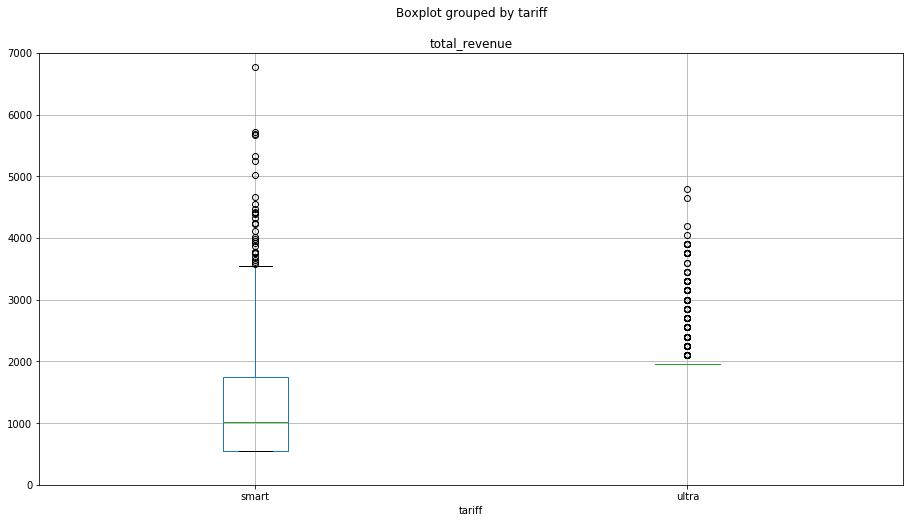

In [57]:
df.boxplot('total_revenue', by = 'tariff', figsize = (15,8)).set_ylim(0, 7000)

По этой диаграмме видим, что для тарифа "Смарт" наблюдается положительное смещение. При этом видим, что большинство пользователей тарифа "Ультра" платят 1950 рублей в месяц, что говорит нам о том, что пользователям "Смарт" пакета услуг не хватает, а вот пользователям "Ультра" наоборот.

Теперь посмотрим на остальные показатели: сколько минут разговора, сколько сообщений, какой объем трафика требуется каждому пользователю тарифа в месяц. Для этого сделаем отдельную выборку по кажому из тарифов.

In [58]:
ultra = df.query('tariff == "ultra"')
smart = df.query('tariff == "smart"')

### Сколько минут разговора <a id="3_1"></a>

Text(0.5, 0, 'Минуты')

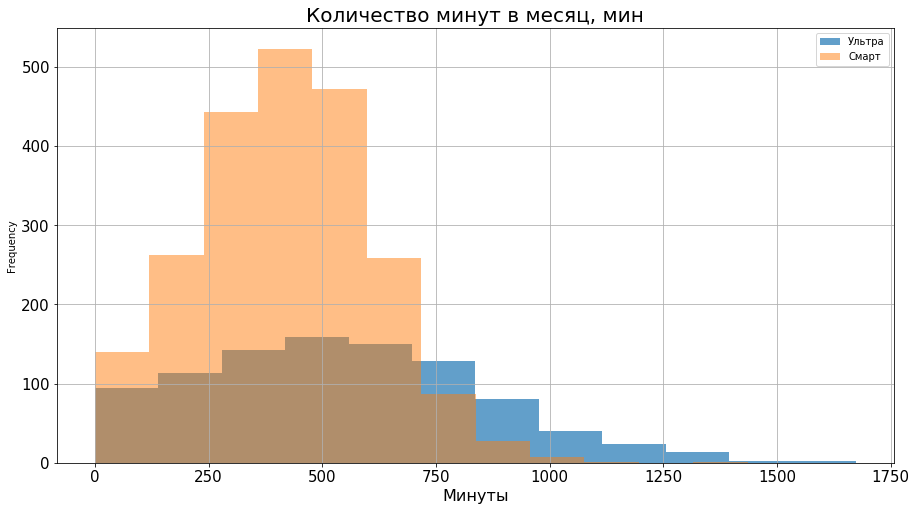

In [59]:
ax = ultra.plot(y = 'calls_duration',
                bins = 12,
                kind = 'hist', 
                alpha = .7, 
                legend = True, 
                label = 'Ультра', 
                grid = True, 
               figsize = (15,8),
               fontsize = 15)
smart.plot(y = 'calls_duration', 
           bins = 12,
           kind = 'hist', 
           alpha = .5,  
           ax = ax,
           label = 'Смарт',
           grid = True)
ax.set_title('Количество минут в месяц, мин', fontsize=20)
ax.set_xlabel('Минуты', fontsize=16)

In [60]:
df.groupby('tariff')['calls_duration'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2223.0,419.062978,189.325618,0.0,285.0,423.0,545.5,1435.0
ultra,951.0,545.451104,306.925754,0.0,310.0,528.0,756.5,1673.0


In [61]:
def disp(df : pd.DataFrame, column : str):
    df_info = df.pivot_table(index = 'tariff', values = column, aggfunc = ['count', 'mean', 'median','var', 'std','min','max'])
    df_info.columns = ['Количество', 'Среднее', 'Медиана','Дисперсия', 'Ст. Отклонение', 'Минимум','Максимум']
    return df_info

In [62]:
disp(df, 'calls_duration')

,Количество,Среднее,Медиана,Дисперсия,Ст. Отклонение,Минимум,Максимум
tariff,,,,,,,
smart,2223,419.062978,423.0,35844.189551,189.325618,0.0,1435.0
ultra,951,545.451104,528.0,94203.418396,306.925754,0.0,1673.0


### Вывод

Видим, что оба тарифа по призаку (количество минут в месяц) имеют положительную скошенность. При этом:
- средняя продолжительность звонка в месяц для тарифа "Смарт" составляет 420 минут; 
- средняя продолжительность звонка в месяц для тарифа "Ультра" составляет 545 минут;
- стандартное отклоение по продолжительности звонков у тарифа "Ультра" больше, чем у тарифа "Смарт"
- пользователи тарифа "Ультра" по продолжительности звонков в месяц больше общаются, чем клиенты с тарифом "Смарт"

### Сколько сообщений <a id="3_2"></a>

Text(0.5, 0, 'Количесвтво сообщений')

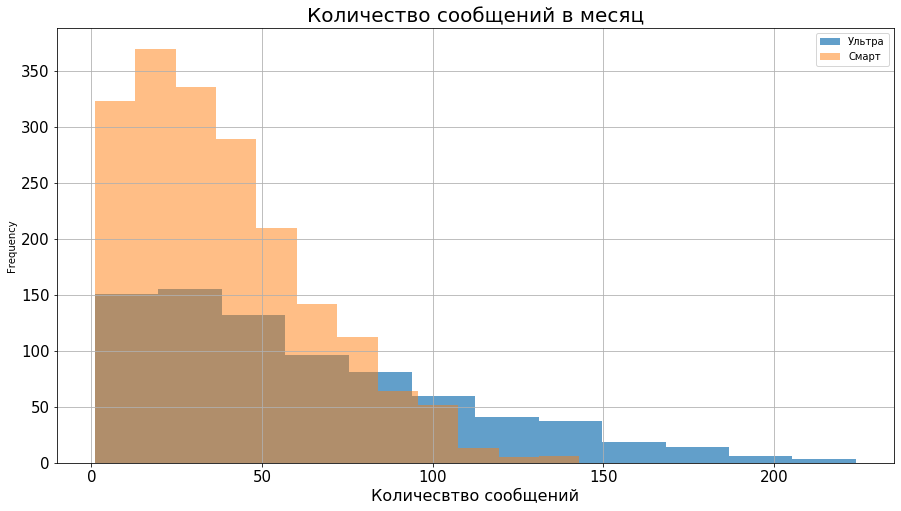

In [63]:
ax = ultra.plot(y = 'msg_count',
                bins = 12,
                kind = 'hist', 
                alpha = .7, 
                legend = True, 
                label = 'Ультра', 
                grid = True, 
               figsize = (15,8),
               fontsize = 15)
smart.plot(y = 'msg_count', 
           bins = 12,
           kind = 'hist', 
           alpha = .5,  
           ax = ax,
           label = 'Смарт',
           grid = True)
ax.set_title('Количество сообщений в месяц', fontsize=20)
ax.set_xlabel('Количесвтво сообщений', fontsize=16)

In [64]:
df.groupby('tariff')['msg_count'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,1922.0,38.716441,26.787949,1.0,17.0,34.0,55.0,143.0
ultra,795.0,61.161006,45.931026,1.0,24.0,51.0,87.5,224.0


<div class="alert alert-info"> <b>Комментарий студента:</b> Добавил дисперсию</div>

In [65]:
disp(df, 'msg_count')

,Количество,Среднее,Медиана,Дисперсия,Ст. Отклонение,Минимум,Максимум
tariff,,,,,,,
smart,1922,38.716441,34.0,717.594201,26.787949,1.0,143.0
ultra,795,61.161006,51.0,2109.659183,45.931026,1.0,224.0


In [66]:
def draw_hist(df1 : pd.DataFrame, df2 : pd.DataFrame, column : str, title : str):
    ax = df1.plot(y = column,
                bins = 12,
                kind = 'hist', 
                alpha = .7, 
                legend = True, 
                label = 'Ультра', 
                grid = True, 
               figsize = (15,8),
               fontsize = 15)
    df2.plot(y = column, 
               bins = 12,
               kind = 'hist', 
               alpha = .5,  
               ax = ax,
               label = 'Смарт',
               grid = True)
    ax.set_title(title + ' в месяц', fontsize=20)
    ax.set_xlabel(title, fontsize=16)

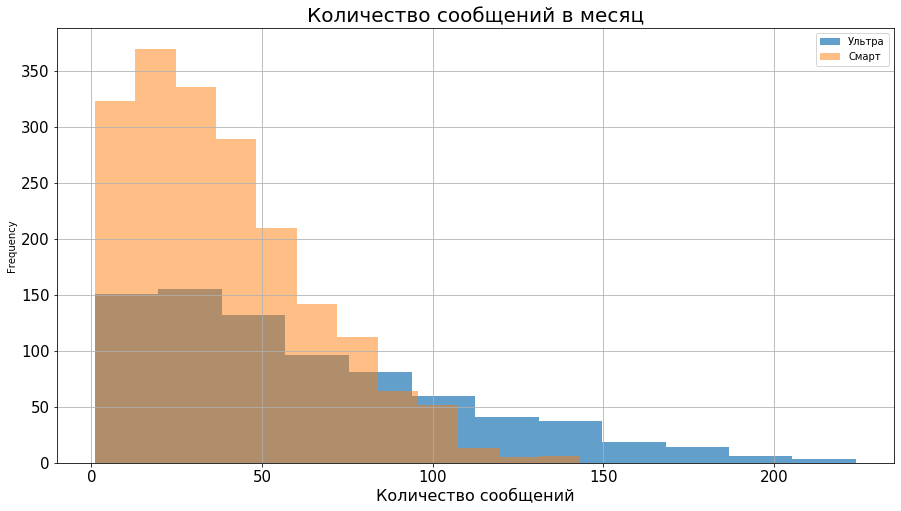

In [67]:
draw_hist(ultra, smart, 'msg_count', 'Количество сообщений')

### Вывод

Видим, что оба тарифа по призаку (количество сообщений в месяц) имеют положительную скошенность. При этом:
- сообщения меньше всего пользуется спросом у клиентов из всех предлагаемых услуг оператором
- среднее количсетво сообщений в месяц для тарифа "Смарт" составляет 39 сообщений; 
- среднее количсетво сообщений в месяц для тарифа "Ультра" составляет 62 сообщение;
- стандартное отклоение по количеству сообщений у тарифа "Ультра" больше, чем у тарифа "Смарт"
- пользователи тарифа "Ультра" больше обмениваются сообщениями, чем клиенты тарифа "Смарт."

### Какой объем интернет-трафика <a id="3_3"></a>

Text(0.5, 0, 'Количество интернет-трафика')

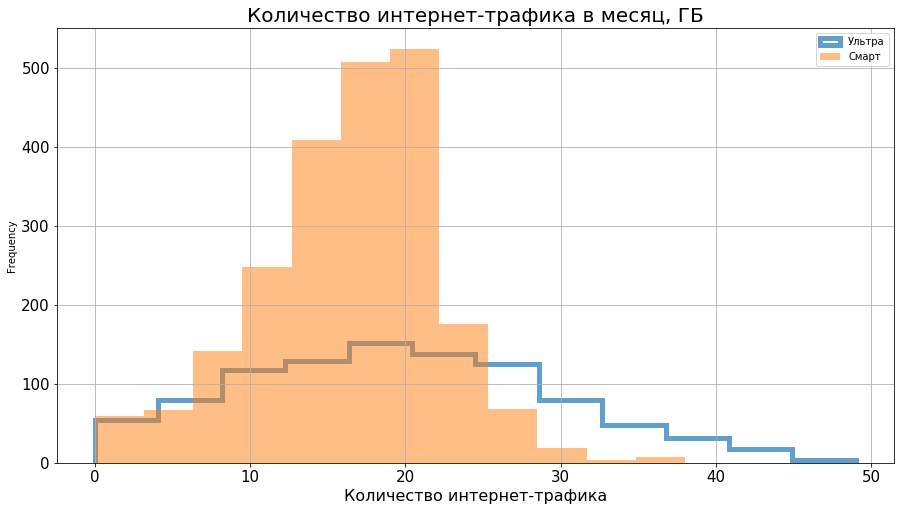

In [68]:
ax = ultra.plot(y = 'gb_sum',
                bins = 12,
                kind = 'hist', 
                alpha = .7, 
                legend = True, 
                label = 'Ультра', 
                grid = True, 
               figsize = (15,8),
                histtype='step',
                linewidth=5,
               fontsize = 15)
smart.plot(y = 'gb_sum', 
           bins = 12,
           kind = 'hist', 
           alpha = .5,  
           ax = ax,
           label = 'Смарт',
           grid = True)
ax.set_title('Количество интернет-трафика в месяц, ГБ', fontsize=20)
ax.set_xlabel('Количество интернет-трафика', fontsize=16)

In [69]:
df.groupby('tariff')['gb_sum'].describe()

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2228.0,16.336176,5.737923,0.0,13.0,17.0,20.0,38.0
ultra,975.0,19.694359,9.702924,0.0,12.0,19.0,27.0,49.0


<div class="alert alert-info"> <b>Комментарий студента:</b> Добавил дисперсию</div>

In [70]:
disp(df, 'gb_sum')

,Количество,Среднее,Медиана,Дисперсия,Ст. Отклонение,Минимум,Максимум
tariff,,,,,,,
smart,2228,16.336176,17.0,32.923756,5.737923,0.0,38.0
ultra,975,19.694359,19.0,94.146734,9.702924,0.0,49.0


### Вывод

А вот здесь видим, что пользователи тарифа "Смарт" стараются себя ограничивать в потреблении интернет-трафика, так как за каждый гигабайт сверх лимита клиент должен доплачивать 200 рублей, чего, естественно, клиент не хочет делать. Отсюда видим отрицательную скошенность по потреблению интернет-трафика у клиентов "Смарт". В то время как пользователи тарифа "Ультра" используют все свои гигабайты и пользуются интернетом сверх лимита, т.е. имеет положительную скошенность. При этом:
- инетрнет-трафик больше всего пользуется спросом у клиентов мобильного оператора
- среднее количсетво гигбайт в месяц для тарифа "Смарт" составляет 17 гигабайт; 
- среднее количсетво гигабайт в месяц для тарифа "Ультра" составляет 20 гигабайт;
- стандартное отклоение по потреблению интернет-трафика у тарифа "Ультра" больше, чем у тарифа "Смарт";
- пользователи тарифа "Ультра"больше потребляют интернет-трафик, чем клиенты тарифа "Смарт".

### Вывод исследования
На основе исследования среднего ежемесячного потребления услуг мобильного оператора (количество минут, сообщений, интернет-трафика) для каждого тарифа можно сказать следующее:
- Меньше всего люди обмениваются сообщениями;
- Больше всего люди пользуются мобильным интернетом;
- пользователям тарифа "Смарт" не хватает количества минут, сообщений и интернет-трафика. Учитывая стоимость каждого гигбайта за превышение лимита, пользователи стремятся не превышать этот лимит;
- большинство пользователей тарифа "Ультра" даже не используют свой тариф "на максимум", за исключением потребления интернет-трафика;
- по ежемесячной выручке тариф "Ультра" - выгодный для бизнеса, несмотря на распределение ежемесячной выручки тарифа "Смарт". При этом не забываем, что больше всего пользователей, которые перестали пользоваться услугами мобильного оператора, пользовались тарифом "Смарт", так как ограничения большие, а стоимость переплат высокая.
- Тарифом "Смарт" пользуются больше, чем тарифом "Ультра".

После того, как провели исследование, проверим некоторые гипотезы.

### Проверка гипотез <a id="3_4"></a>

После того, как провели исследование, проверим следующие гипотезы:
- **Средняя выручка пользователей тарифов "Смарт" и "Ультра" различаются**
- **Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов**

Прежде всего посмотрим еще раз на гистограммы размаха ежемесячной выручки по тарифам:

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(0, 7000)

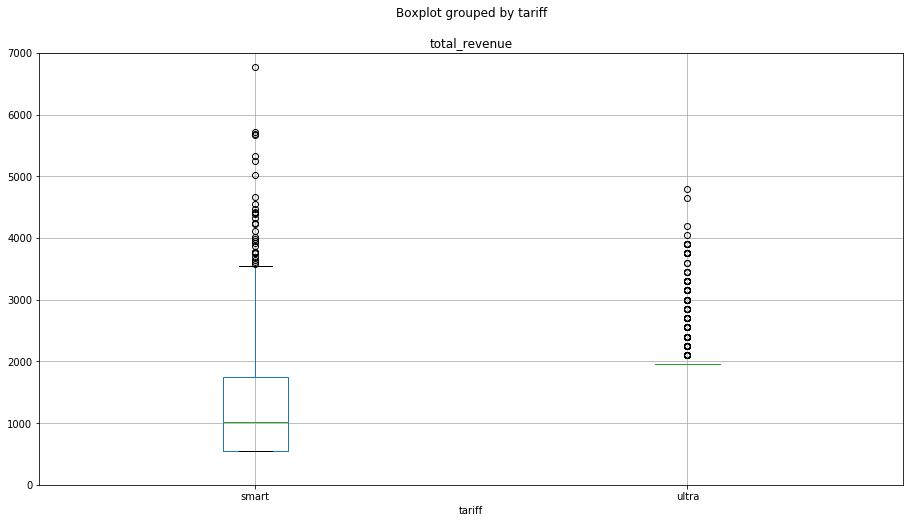

In [71]:
df.boxplot('total_revenue', by = 'tariff', figsize = (15,8)).set_ylim(0, 7000)

Видим, что у нас есть выбросы в каждом тарифе. Так как для проведения проверки двух выборок мы будем использовать **t-критерий Стьюдента**, поскольку выборки между собой независимы. Однако данный критерий неустойчив к выбросам и аномальным значениям. Поэтому прежде всего избавимся в нашей выборке от выбросов.

In [72]:
def kill_anomaly(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    df_iqr = ((df[column] >= q1 + 1.5*iqr) & (df[column] <= q3 + 1.5*iqr))
    return df.loc[df_iqr]

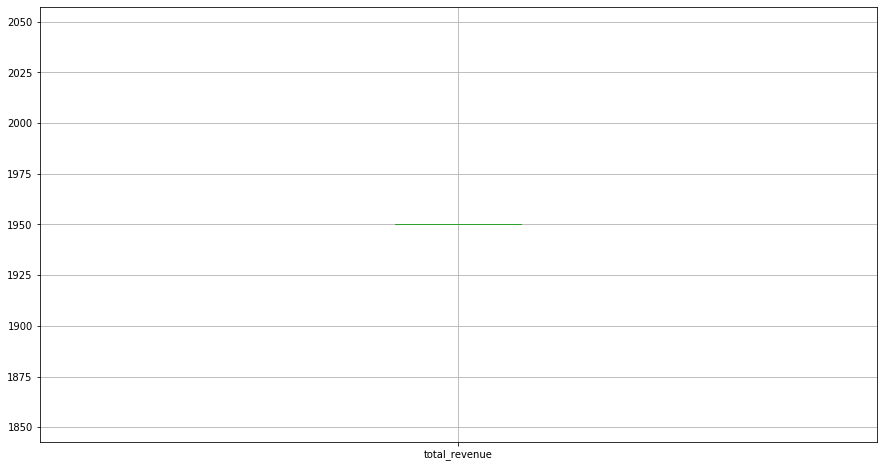

In [73]:
ultra_filtered = kill_anomaly(ultra, 'total_revenue')
ultra_filtered.boxplot('total_revenue', figsize = (15,8))

In [74]:
smart_filtered = kill_anomaly(smart, 'total_revenue')

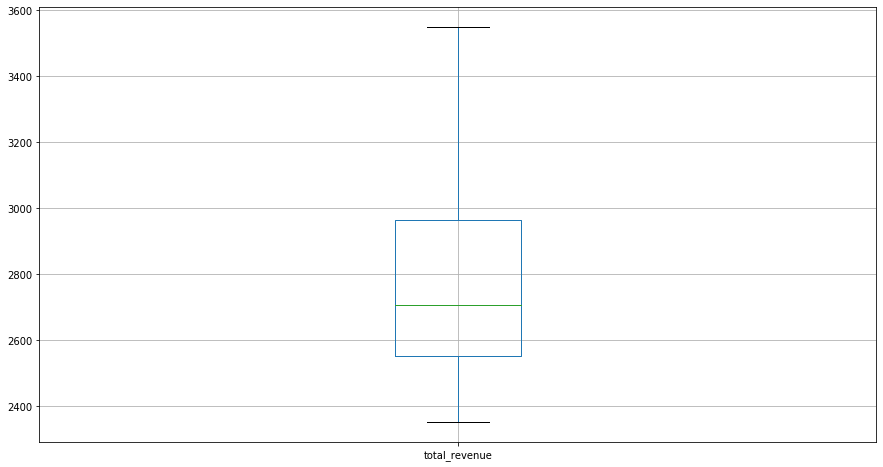

In [75]:
smart_filtered.boxplot('total_revenue', figsize = (15,8))

Мы избавились от выбросов. Теперь рассмотрим гипотезу:
- **Средняя выручка пользователей тарифов "Смарт" и "Ультра" различаются**

Для этого сформируем нулевую и альтернативную гипотезы:
- **H0**: средняя выручка пользователей тарифов "Смарт" и "Ультра" **не различаются**;
- **H1**: средняя выручка пользователей тарифов "Смарт" и "Ультра" **различаются**

<div class="alert alert-info"> <b>Комментарий студента:</b> Добавлено обоснование применения параметра на основании сравнения дисперсий </div>

Рассмотрим нашу исходную таблицу:

In [76]:
disp(df, 'total_revenue')

,Количество,Среднее,Медиана,Дисперсия,Ст. Отклонение,Минимум,Максимум
tariff,,,,,,,
smart,2229,1289.973531,1023.0,669785.708006,818.404367,550.0,6770.0
ultra,985,2070.152284,1950.0,141516.745079,376.187114,1950.0,4800.0


Теперь сравним дисперсии двух выборок после очистки от выбросов:

In [77]:
disp(ultra_filtered, 'total_revenue')

,Количество,Среднее,Медиана,Дисперсия,Ст. Отклонение,Минимум,Максимум
tariff,,,,,,,
ultra,851,1950.0,1950.0,0.0,0.0,1950.0,1950.0


In [78]:
disp(smart_filtered, 'total_revenue')

,Количество,Среднее,Медиана,Дисперсия,Ст. Отклонение,Минимум,Максимум
tariff,,,,,,,
smart,228,2771.307018,2704.0,107656.698277,328.110802,2350.0,3550.0


Видим, что у пользователей тарифа "Смарт" и "Ультра" дисперсии ежемесячной выручки сильно отличаются. Поэтому в процессе сравнения выборок будем использовать параметр `equal_var = False`

In [79]:
# Делаем выборку по каждому тарифу с оценкой параметра: ежемесячная выручка
smart_filtered = smart_filtered[['total_revenue']]
ultra_filtered = ultra_filtered[['total_revenue']]
# задаем попроговое значение
alpha = .05
results = (
    st.ttest_ind(smart_filtered, ultra_filtered, equal_var = False)
)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-value: [6.50477856e-100]
Отвергаем нулевую гипотезу


Видим, что вероятность близка к нулю. Это говорит нам о том, что нулевая гипотеза отвергается. 

Средняя выручка между тарифами "Смарт" и "Ультра" различаются. 

Теперь посмотрим на следующую гипотезу:
- **Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов**

Для этого сделаем две выборки из нашей комбинированной таблицы:
- Город Москва;
- Остальные города (другие регионы)

In [80]:
moscow = df.query('city == "Москва"')
region = df.query('city != "Москва"')

Посмотрим на диаграмму размаха для каждой выборки.

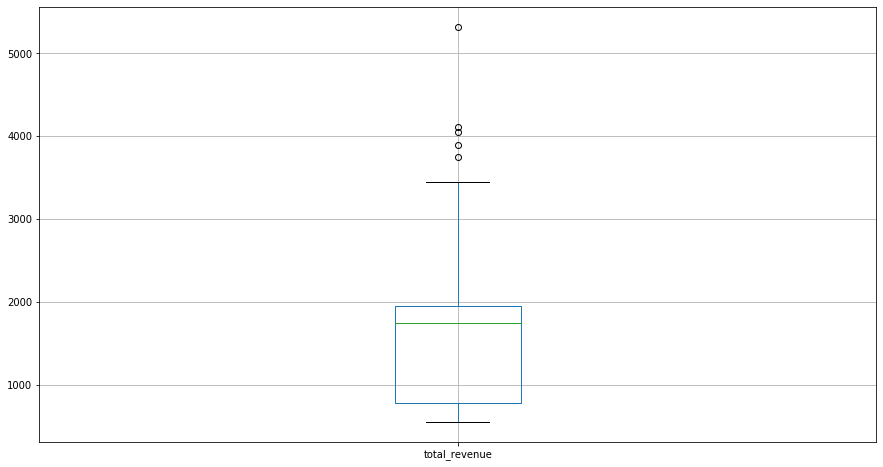

In [81]:
moscow.boxplot('total_revenue', figsize = (15,8))

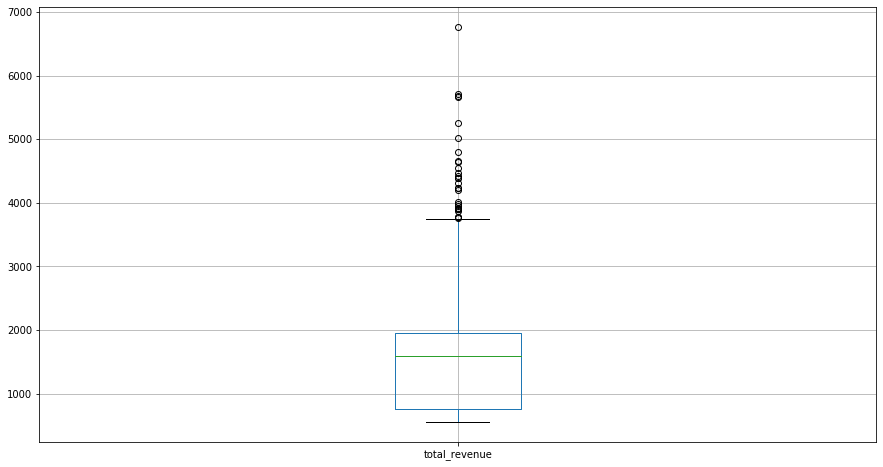

In [82]:
region.boxplot('total_revenue', figsize = (15,8))

Видим, что в выборках есть аномальные значения. Избавимся от них, так как они могут повлиять на результат проверки гипотезы.

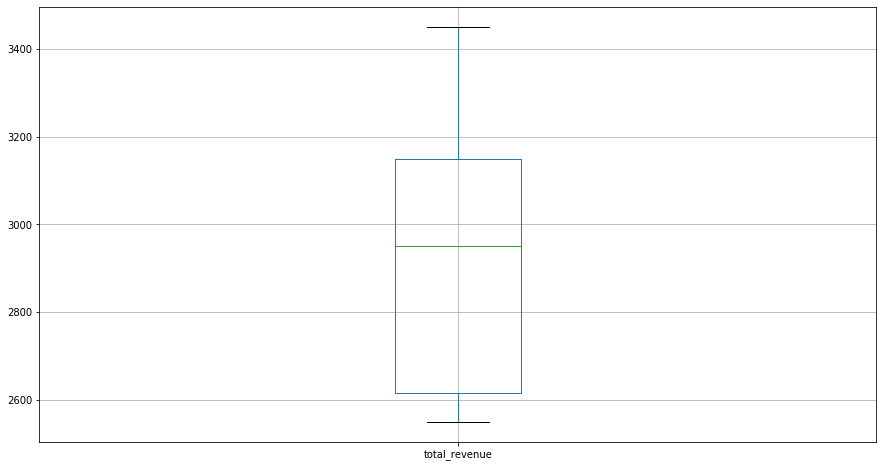

In [83]:
moscow_filtered = kill_anomaly(moscow, 'total_revenue')
moscow_filtered.boxplot('total_revenue', figsize = (15,8))

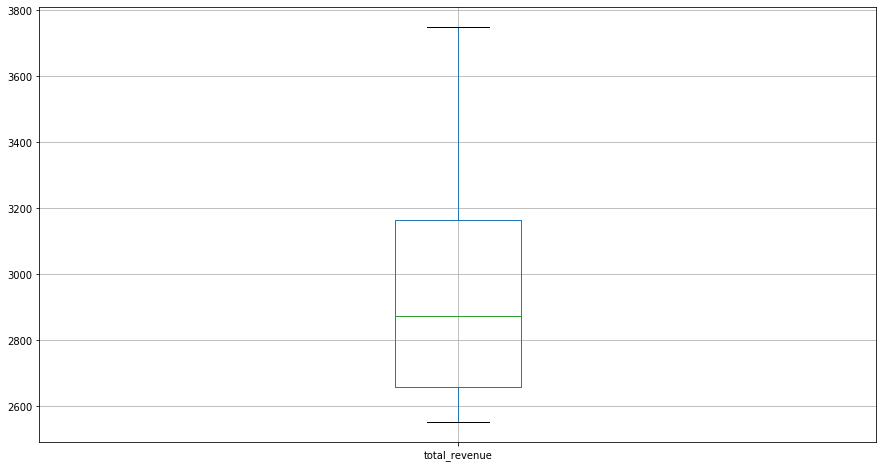

In [84]:
region_filtered = kill_anomaly(region, 'total_revenue')
region_filtered.boxplot('total_revenue', figsize = (15,8))

Видим, что от выбросов мы избавились, теперь рассмотрим нашу гипотезу:
- **Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов**

Для этого сформируем нулевую и альтернативную гипотезы:
- **H0**: средняя выручка пользователей из Москвы и других регионов **не различаются**;
- **H1**: средняя выручка пользователей из Москвы и других регионов **различаются**

<div class="alert alert-info"> <b>Комментарий студента:</b> Добавлено обоснование применения параметра на основании сравнения дисперсий </div>

Рассмотрим наши отфильтрованные от выбросов выборки. Сравним их дисперсии:

In [85]:
moscow_df = moscow_filtered['total_revenue'].agg(['count', 'mean', 'median','var', 'std', 'min', 'max'])
moscow_df

count        45.000000
mean       2917.888889
median     2950.000000
var       79386.873737
std         281.756763
min        2550.000000
max        3450.000000
Name: total_revenue, dtype: float64

In [86]:
region_df = region_filtered['total_revenue'].agg(['count', 'mean', 'median','var', 'std', 'min', 'max'])
region_df

count        208.000000
mean        2956.134615
median      2871.500000
var       125513.788554
std          354.279252
min         2550.000000
max         3750.000000
Name: total_revenue, dtype: float64

Видим, что дисперсии этих выборок отличаются. Отсюда следует, что при проверке этих выборок необходимо применить параметра `equal_var = False` для получения более точного результата.

In [87]:
# Делаем выборку по каждому тарифу с оценкой параметра: ежемесячная выручка
moscow_filtered = moscow_filtered[['total_revenue']]
region_filtered = region_filtered[['total_revenue']]
# задаем попроговое значение
alpha = .05
results = (
    st.ttest_ind(moscow_filtered, region_filtered, equal_var = False)
)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-value: [0.43426147]
Не удалось отвергнуть нулевую гипотезу


Видим, что вероятность составляет приблизительно 50%. Что говорит нам о том, что гипотезу отвергнуть не удалось. Полученное значение p-value говорит о том, что вероятность получить такое или большее различие случайно почти 50%. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средними чеками.

### Вывод
Провели проверку следующих гипотез:
- **Средняя выручка пользователей тарифов "Смарт" и "Ультра" различаются**
- **Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов**

Однако перед проверкой гипотез обнаружили выбросы, которые могли полвиять на результат проверки гипотез.
После очистки от выбросов провели проверку гипотез, по результатам которых установили следующее:
- гипотеза средняя выручка пользователей тарифов "Смарт" и "Ультра" **не различаются** **отвергается**;
- **не удалось отвергнуть** гипотезу средняя выручка пользователей из Москвы и других регионов **не различаются**.

<div class="alert alert-info"> <b>Комментарий студента:</b> Сделаем))) </div>

In [1]:
def hypotesis_check(s1 : pd.Series, s2 : pd.Series):
    alpha = .05
    results = (
        st.ttest_ind(s1, s2)
    )

    print('p-value:', results.pvalue)

    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не удалось отвергнуть нулевую гипотезу')

NameError: name 'pd' is not defined

In [89]:
hypotesis_check(moscow_filtered[['total_revenue']], region_filtered[['total_revenue']])

p-value: [0.49785707]
Не удалось отвергнуть нулевую гипотезу


## Общий вывод <a id="4"></a>

В рамках исследования познакомились с выборкой клиентов "Мегалайна". 
В процессе предобработки данных были установлены следующие недочеты:

- несоответствие типов данных во времени
- аномальные значения в количестве минут разговора и количестве потребления интернет-трафика. 

В итоге, было предложено оставить пропуски и аномальные значения как есть, так как удалив пропуски, мы могли бы потерять часть данных, которые могли бы повлиять на результаты исследования, а заполнение пропусков нестандартным значением могли бы исказить результаты.

**Рекомендация:** провести корректную подготовку данных для анализа, чтобы не было значений, связанных с пропущенными звонками, обрывом связи, неудачных-интернет-сессий

В процессе исследования поведение пользователей по целевым показателям тарифа: количество минут, сообщений, гигабайт увидели, что:
- Меньше всего люди обмениваются сообщениями;
- Больше всего люди пользуются мобильным интернетом;
- пользователям тарифа "Смарт" не хватает количества минут, сообщений и интернет-трафика. Учитывая стоимость каждого гигбайта за превышение лимита, пользователи стремятся не превышать этот лимит;
- большинство пользователей тарифа "Ультра" даже не используют свой тариф "на максимум", за исключением потребления интернет-трафика;
- по ежемесячной выручке тариф "Ультра" - выгодный для бизнеса, несмотря на распределение ежемесячной выручки тарифа "Смарт". При этом не забываем, что больше всего пользователей, которые перестали пользоваться услугами мобильного оператора, пользовались тарифом "Смарт", так как ограничения большие, а стоимость переплат высокая.
- Тарифом "Смарт" пользуются больше, чем тарифом "Ультра".

Также стоит отметить, что на момент сбора данных, 38 пользователей перестало пользоваться тарифами, большинство из них ранее пользовались тарифом "Смарт".

Поэтому хочется оставить следующие **рекомендации**:
- пересмотреть тариф "Смарт" и подобрать наиболее оптимальный набор пакета минут, сообщений, гигабайт. 
- добавить конфигурацию тарифа, где пользователь, может сам выбрать оптимальный набор пакета;
- уделить внимание пакету гигабайтов в месяц, в тарифе "Смарт" 15 ГБ в месяц - недостаточно для пользователя, а переплатата за каждый гигабайт - высокая.

В конце исследования провели проверку гипотез, в результате которой определили:
- гипотеза: средняя выручка пользователей тарифов "Смарт" и "Ультра" **не различаются** **отвергается**;
- **не удалось отвергнуть** гипотезу: средняя выручка пользователей из Москвы и других регионов **не различаются**.

На основе выборки, можно сказать, что для бизнеса более выгодным тариф оказался "Ультра"